In this notebook, I will use Poutyne (a simplified framework for PyTorch) for the specified cats vs dogs classification task.

In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import glob
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Downloading the dataset

In [3]:
!gsutil -mq cp gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip ./

In [ ]:
!unzip cats_vs_dogs_dataset.zip -d /content/drive/MyDrive/Dataset/


In [5]:
import os
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/train/dogs')))
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/train/cats')))
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/test/dogs')))
print(len(os.listdir('/content/drive/MyDrive/Dataset/dataset/test/cats')))

8995
8995
1227
3505


#### Installing and importing Libraries

In [ ]:
!pip install wandb
!pip install efficientnet_pytorch
!pip install timm
!pip install poutyne

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import os
import wandb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from poutyne import set_seeds, Model, ModelCheckpoint, Callback, CSVLogger

In [9]:
# Setting up WANDB
wandb.login()

wandb: Currently logged in as: rifat004. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [18]:
wandb.init(project="CatvsDog_EfficientNetV2B2", name='Poutyne_Ev2B2_Not_Pretrained_run5',
           config={"learning_rate": 0.01, "epochs": 18}
           )


### Data Augmentation and Splitting into Train-Validation-Test

In [19]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

set_seeds(42)

# Define paths to your training and test data directories
train_data_dir = '/content/drive/MyDrive/Dataset/dataset/train'
test_data_dir = '/content/drive/MyDrive/Dataset/dataset/test'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-45, 45)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load train dataset
train_dataset = ImageFolder(root=train_data_dir, transform=transform)

# Calculate the number of samples for validation
validation_size = int(0.15 * len(train_dataset))

# Split the train dataset into train and validation sets using train_test_split
train_indices, validation_indices = train_test_split(
    range(len(train_dataset)),
    test_size=validation_size,
    stratify=train_dataset.targets,  # Making sure the class distribution is preserved
    random_state=42
)

# Create Subset classes for train and validation datasets
train_subset = Subset(train_dataset, train_indices)
validation_subset = Subset(train_dataset, validation_indices)

# Define batch size and create data loaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)

# Load test dataset
test_dataset = ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset: {len(train_subset)} images belonging to {len(train_dataset.classes)} classes.")
print(f"Validation dataset: {len(validation_subset)} images belonging to {len(train_dataset.classes)} classes.")
print(f"Test dataset: {len(test_dataset)} images belonging to {len(test_dataset.classes)} classes.")

Train dataset: 15292 images belonging to 2 classes.
Validation dataset: 2698 images belonging to 2 classes.
Test dataset: 4732 images belonging to 2 classes.


### Model Definition

In [ ]:
#to check the list of PyTorch Image Models
timm.list_models()

In [20]:
# Checking for GPU availability and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the EfficientNetV2-B2 model
e_netv2b2 = timm.create_model('tf_efficientnetv2_b2', pretrained=False, num_classes=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(e_netv2b2.parameters(), lr=0.001)

# Defining the Poutyne model
model = Model(e_netv2b2, optimizer, criterion, batch_metrics=['accuracy'], device=device)

### Defining Callbacks

Here, I want to save the model weights after each epoch in drive

In [21]:
# Define the directory for saving model weights to Google Drive
drive_checkpoint_dir = '/content/drive/MyDrive/Dataset/Weights'
log_checkpoint_dir='/content/drive/MyDrive/Dataset/Logs'

callbacks = [
   # Define the ModelCheckpoint callback for Google Drive
    ModelCheckpoint(
    os.path.join(drive_checkpoint_dir, 'Poutyne_EfficientNetV2B2_Not_pretrained_{epoch}.pth'),
    monitor="val_acc",
    mode="max",
    save_best_only=False,
    restore_best=False,
    verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(log_checkpoint_dir, 'log_catvsdog_poutyne_not_pretrained.tsv'), separator='\t'),
]

## Training and Validation

In [23]:
#poutine's fit_generator returns a dictionary in a list
history_list = model.fit_generator(train_loader, validation_loader, epochs=18, callbacks= callbacks)

# Iterate through the history_list
for epoch_info in history_list:
    epoch = int(epoch_info['epoch'])
    train_loss = float(epoch_info['loss'])
    train_accuracy = float(epoch_info['acc'])
    val_loss = float(epoch_info['val_loss'])
    val_accuracy = float(epoch_info['val_acc'])

    # Log metrics to WandB for each epoch
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_acc': train_accuracy,
        'val_loss': val_loss,
        'val_acc': val_accuracy
    })

# Finish the WandB run
wandb.finish()

Epoch:  1/18 Train steps: 478 Val steps: 85 5m24.22s loss: 0.958136 acc: 61.568140 val_loss: 1.544858 val_acc: 57.746479
Epoch 1: saving file to /content/drive/MyDrive/Dataset/Weights/Poutyne_EfficientNetV2B2_Not_pretrained_1.pth
Epoch:  2/18 Train steps: 478 Val steps: 85 5m23.89s loss: 0.649459 acc: 66.695004 val_loss: 1.044421 val_acc: 66.975537
Epoch 2: saving file to /content/drive/MyDrive/Dataset/Weights/Poutyne_EfficientNetV2B2_Not_pretrained_2.pth
Epoch:  3/18 Train steps: 478 Val steps: 85 5m22.63s loss: 0.604402 acc: 69.631180 val_loss: 0.701865 val_acc: 70.051890
Epoch 3: saving file to /content/drive/MyDrive/Dataset/Weights/Poutyne_EfficientNetV2B2_Not_pretrained_3.pth
Epoch:  4/18 Train steps: 478 Val steps: 85 5m16.62s loss: 0.561426 acc: 72.240387 val_loss: 0.543803 val_acc: 73.461824
Epoch 4: saving file to /content/drive/MyDrive/Dataset/Weights/Poutyne_EfficientNetV2B2_Not_pretrained_4.pth
Epoch:  5/18 Train steps: 478 Val steps: 85 5m14.72s loss: 0.537005 acc: 73.9079

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▃▅▆▇▄▆▆▅▅▆▆▇▇██▇█
train_loss,█▃▃▂▂▃▂▂▂▂▂▂▁▂▁▁▂▁
val_acc,▁▄▅▆▇▆▆▇▅▇▆▇▇▆█▆█▇
val_loss,▆▃▂▁▁▁▁▃█▁▁▁▁▂▁▁▁▁
epoch,18
train_acc,77.18415
train_loss,0.47935
val_acc,73.72128
val_loss,0.5227


In [24]:
#we also can see the logs from saved logs
import pandas as pd
logs = pd.read_csv(os.path.join(log_checkpoint_dir, 'log_catvsdog_poutyne_not_pretrained.tsv'), sep='\t')
print(logs)

    epoch        time     lr      loss        acc  val_loss    val_acc
0       1  324.223060  0.001  0.958136  61.568140  1.544858  57.746479
1       2  323.885858  0.001  0.649459  66.695004  1.044421  66.975537
2       3  322.631642  0.001  0.604402  69.631180  0.701865  70.051890
3       4  316.623783  0.001  0.561426  72.240387  0.543803  73.461824
4       5  314.715682  0.001  0.537005  73.907926  0.523916  75.463306
5       6  313.365584  0.001  0.600921  69.291133  0.534055  73.202372
6       7  316.392620  0.001  0.537404  73.489406  0.557717  72.127502
7       8  317.642045  0.001  0.542951  73.430552  1.002103  73.980726
8       9  311.585302  0.001  0.571936  71.246403  2.125677  69.014085
9      10  312.723493  0.001  0.574429  70.697097  0.523303  74.351371
10     11  313.093119  0.001  0.551647  72.436568  0.558241  72.312824
11     12  308.159587  0.001  0.538281  73.463249  0.521471  74.203113
12     13  311.886597  0.001  0.511238  75.346586  0.531310  73.721275
13    

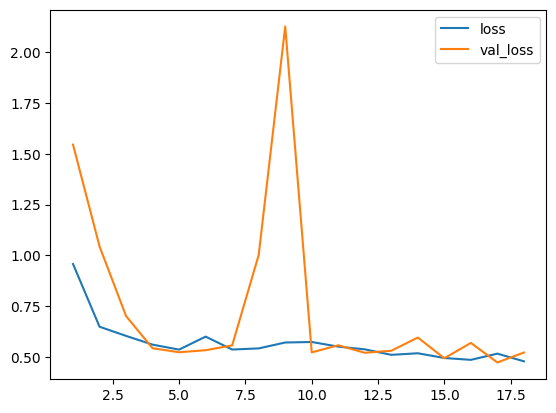

In [25]:
#plotting training and validation loss
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

In [26]:
#finding best epoch
best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

Best epoch: 17


### Evaluating the model on test set

In [27]:
#loading best saved weight to the model
model = Model(e_netv2b2, optimizer, criterion, batch_metrics=['accuracy'], device=device)
model.load_weights('/content/drive/MyDrive/Dataset/Weights/Poutyne_EfficientNetV2B2_Not_pretrained_17.pth')

test_loss, test_acc,  = model.evaluate_generator(test_loader)

Test steps: 148 1m12.98s test_loss: 0.451265 test_acc: 79.163145                              


Classification Report:
              precision    recall  f1-score   support

        cats       0.89      0.80      0.84      3505
        dogs       0.56      0.73      0.63      1227

    accuracy                           0.78      4732
   macro avg       0.73      0.76      0.74      4732
weighted avg       0.81      0.78      0.79      4732



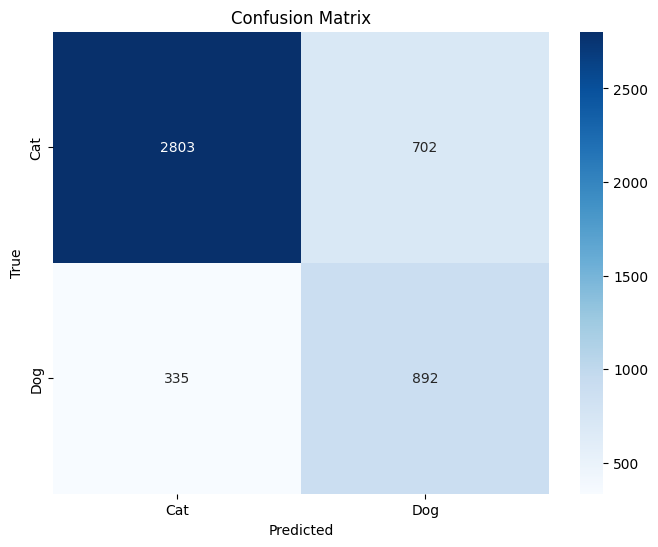

In [28]:
# Calculate classification report and printing confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model.predict_on_batch(inputs)  # Use predict_on_batch to get predictions
        predicted = np.argmax(outputs, axis=1)  # Get the class with the highest probability
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted)

class_names = test_dataset.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()